# Imports

In [1]:
import string
import shutil
import torch
import random
import math
import h5py
import os
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from sklearn.manifold import TSNE
from torch.optim import lr_scheduler
from google.colab import drive
from google.colab import runtime
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchsummary import summary
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install audiomentations
!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, TimeMask

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.0 MB/s eta 0:00:00
Mounted at /content/drive


# Data

In [2]:
with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/test_data.h5', 'r') as test_file:
    test_data = np.array(test_file['data'])
    test_labels = np.array(test_file['labels'])

MNIST (Testing)

In [3]:
# mean, std = 0.1307, 0.3081

# # Define transforms
# transform = v2.Compose([
#     v2.Resize((64, 64)),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize((mean,), (std,))
# ])

# # Load datasets
# train_dataset = MNIST('../data/MNIST', train=True, download=True, transform=transform)
# test_dataset = MNIST('../data/MNIST', train=False, download=True, transform=transform)

# # Define the target number of samples
# num_train_samples = 6400
# num_val_samples = 1600

# # Shuffle and select a subset of the training dataset
# train_indices = np.random.permutation(len(train_dataset))[:num_train_samples]
# train_subset = Subset(train_dataset, train_indices)

# # Shuffle and select a subset of the validation dataset
# val_indices = np.random.permutation(len(test_dataset))[:num_val_samples]
# val_subset = Subset(test_dataset, val_indices)

# # Create DataLoaders for the subsets
# kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
# train_loader = DataLoader(train_subset, shuffle=True, batch_size=256, **kwargs)
# val_loader = DataLoader(val_subset, batch_size=256, **kwargs)

Data Augmentation

In [4]:
class DataAugmentation(nn.Module):
    def __init__(self):
        super(DataAugmentation, self).__init__()
        self.transforms = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            TimeMask(min_band_part=0.1, max_band_part=0.15, p=0.5),
        ])

    def forward(self, song, sample_rate):
        augmented_song = self.transforms(song, sample_rate=sample_rate)
        return augmented_song

Create Dataset

In [5]:
class AudioDataset(Dataset):
    def __init__(self, input_data, input_labels, sample_rate=16000, n_mels=128, mean=6.5304, std=11.8924, transform=None):
        self.input_data = input_data
        self.input_labels = input_labels
        self.sr = sample_rate
        self.n_mels = n_mels
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mel_spec_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels, n_fft=2048, hop_length=512)
        self.log_mel_spec_transform = T.AmplitudeToDB()
        self.image_transforms = transform = v2.Compose([
                                                        v2.ToImage(),
                                                        v2.ToDtype(torch.float32, scale=True),
                                                        v2.Normalize((self.mean,), (self.std,))
                                                    ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song, self.sr)

        mel_spec = self.mel_spec_transform(torch.from_numpy(song))
        log_mel_spec = self.log_mel_spec_transform(mel_spec)
        mel_spec_tensor = log_mel_spec.unsqueeze(0)
        mel_spec_tensor = self.image_transforms(mel_spec_tensor)

        return mel_spec_tensor, genre

audio_train_dataset = AudioDataset(input_data=train_data, input_labels=train_labels, transform=DataAugmentation())
audio_val_dataset = AudioDataset(input_data=val_data, input_labels=val_labels, transform=None)
audio_test_dataset = AudioDataset(input_data=test_data, input_labels=test_labels, transform=None)

audio_train_loader = DataLoader(audio_train_dataset, batch_size=32, shuffle=True, pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_size=32, pin_memory=True)
audio_test_loader = DataLoader(audio_test_dataset, batch_size=32, pin_memory=True)

Display Dataloader Images

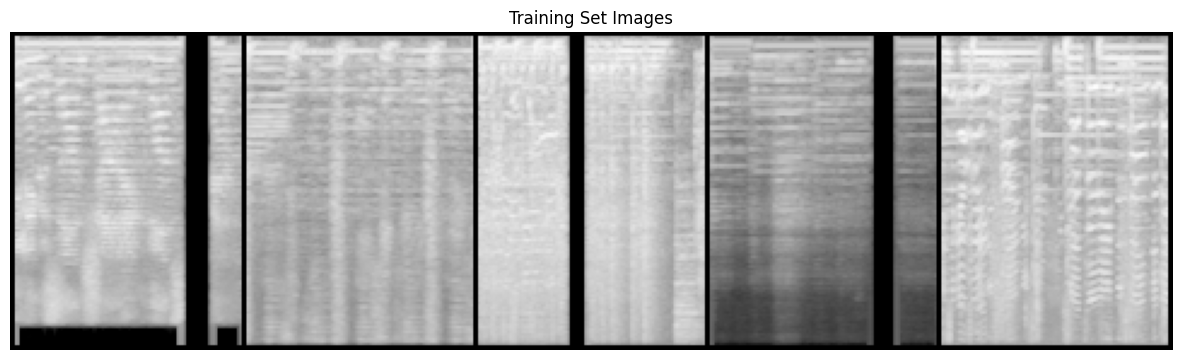

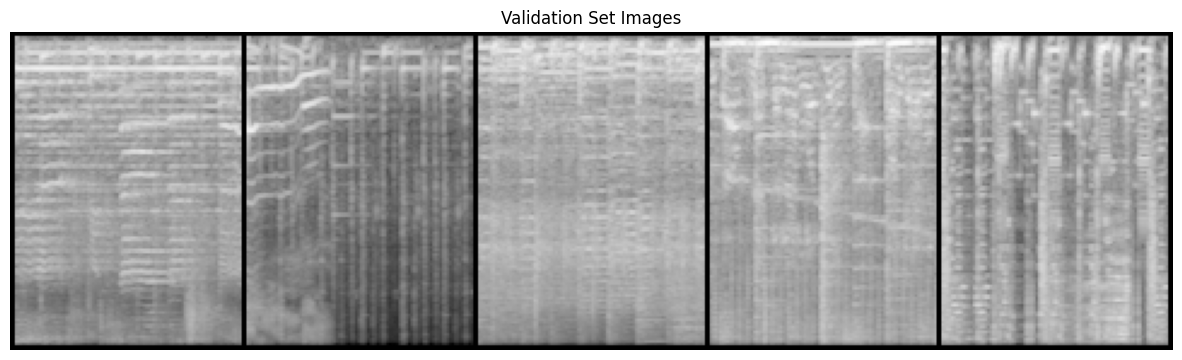

In [6]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    # Get a batch of images
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    # Select 5 random indices
    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    # Call the helper function to show images
    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(audio_train_loader, title="Training Set Images")
plot_images_from_loader(audio_val_loader, title="Validation Set Images")

Mean and Stdev Calculation

In [7]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

# Model

Print Layer (debugging)

In [8]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Positional Encoding

In [11]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding1d(nn.Module):
    def __init__(self, d_model, length):
        super(PositionalEncoding1d, self).__init__()
        if d_model % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dim (got dim={:d})".format(d_model))
        pe = torch.zeros(length, d_model)
        position = torch.arange(0, length).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                            -(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe


class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [7]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv1d, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool, two_dim: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short
        self.two_dim = two_dim

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            if self.two_dim:
              layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            else:
              layers.append(SeparableConv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            if self.two_dim:
              self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
            else:
              self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            if self.two_dim:
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            else:
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

Embedding Model

In [9]:
class ClassificationModel(nn.Module):
    def __init__(self):
      super(ClassificationModel, self).__init__()
      self.input = nn.Sequential(SeparableConv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                                 nn.SELU())
      self.positional_encoding = PositionalEncoding2d(64, 128, 130)


      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
      )

      self.attention = nn.MultiheadAttention(embed_dim=16, num_heads=2, dropout=0.5, batch_first=True)

      self.dense_layers = nn.Sequential(
          nn.Linear(in_features=256, out_features=512, bias=False),
          nn.SELU(),
          nn.Linear(in_features=512, out_features=256, bias=False),
          nn.SELU(),
          nn.Linear(in_features=256, out_features=128, bias=False),
          nn.SELU(),
          nn.Dropout(0.5),
      )

      self.output = nn.Linear(128, 8)

    def forward(self, x):
      x = self.input(x)
      # x = F.layer_norm(self.positional_encoding(x), x.shape)
      x = self.conv_layers(x)

      # batch_size, channels, height, width = x.size()
      # x = x.view(batch_size, channels, height * width)
      # attention_output, _ = self.attention(x, x, x)
      # x = F.layer_norm(x + attention_output, x.shape)

      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      out = self.output(x)
      return out

    def get_embedding(self, x):
      return self.forward(x)

# Utils

Early Stopping

In [13]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.max_accuracy = float('-inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def reset_loss(self):
        self.min_validation_loss = float('inf')

Autoclip

In [14]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [3]:
def save_checkpoint(model, optimizer, scheduler, num_epochs, train_losses, val_losses):
  checkpoint = {
          'epoch': num_epochs + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, '/content/drive/My Drive/Projects/NeuraBeat/model_checkpoint.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses

# Training Loop

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()
model = ClassificationModel().to(device)
start_epoch = 0
num_epochs = 100
learning_rate = 1e-4

classification_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10)
early_stopping = EarlyStopping(patience=3)
scaler = torch.cuda.amp.GradScaler()
autoclipper = AutoClip(percentile=10)

writer = SummaryWriter()

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/model_checkpoint.pt'
if os.path.isfile(checkpoint_path):
    model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
    print(f"Loaded checkpoint from epoch {start_epoch}")

def train_loop(train_loader, model, criterion, optimizer, device, epoch):
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    total_correct = 0
    total_samples = 0

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets)

        train_loss += loss.item()
        scaler.scale(loss).backward()
        autoclipper(model)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        scaler.step(optimizer)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())

    accuracy = 100 * total_correct / total_samples
    train_loss = train_loss / num_batches
    return train_loss, accuracy, skip_lr_sched

def val_loop(val_loader, model, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == targets).sum()
            total_samples += targets.size(0)

            val_loss += loss.item()

    accuracy = 100 * total_correct / total_samples
    val_loss /= num_batches
    return val_loss, accuracy

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, train_accuracy, skip_lr_sched = train_loop(audio_train_loader, model, classification_loss_fn, optimizer, device, epoch+1)
    val_loss, val_accuracy = val_loop(audio_val_loader, model, classification_loss_fn, device, epoch+1)
    print(f"Train loss: {train_loss:>8f} - Train Accuracy: {train_accuracy:>f} - Val loss: {val_loss:>8f} - Val Accuracy: {val_accuracy:>f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses)

    # early_stop_result = early_stopping.early_stop(val_loss)
    # if early_stop_result:
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    print("Last learning rate:", scheduler.get_last_lr())
    if not skip_lr_sched:
        scheduler.step()

writer.close()

Loaded checkpoint from epoch 46
Epoch 47
-------------------------------


100%|██████████| 1782/1782 [27:02<00:00,  1.10it/s]


Train loss: 1.193758 - Train Accuracy: 59.020763 - Val loss: 1.113901 - Val Accuracy: 61.531990 

Last learning rate: [5e-05]
Epoch 48
-------------------------------


100%|██████████| 1782/1782 [25:47<00:00,  1.15it/s]


Train loss: 1.167424 - Train Accuracy: 59.944935 - Val loss: 1.116337 - Val Accuracy: 62.457916 

Last learning rate: [3.4549150281252636e-05]
Epoch 49
-------------------------------


100%|██████████| 1782/1782 [26:09<00:00,  1.14it/s]


Train loss: 1.158632 - Train Accuracy: 60.260592 - Val loss: 1.097937 - Val Accuracy: 62.429855 

Last learning rate: [2.061073738537635e-05]
Epoch 50
-------------------------------


100%|██████████| 1782/1782 [25:53<00:00,  1.15it/s]


Train loss: 1.142151 - Train Accuracy: 61.083053 - Val loss: 1.083069 - Val Accuracy: 62.640293 

Last learning rate: [9.549150281252633e-06]
Epoch 51
-------------------------------


100%|██████████| 1782/1782 [25:39<00:00,  1.16it/s]


Train loss: 1.134383 - Train Accuracy: 60.897166 - Val loss: 1.077780 - Val Accuracy: 62.934906 

Last learning rate: [2.4471741852423237e-06]
Epoch 52
-------------------------------


100%|██████████| 1782/1782 [25:51<00:00,  1.15it/s]


Train loss: 1.234649 - Train Accuracy: 57.375842 - Val loss: 1.175640 - Val Accuracy: 59.217175 

Last learning rate: [0.0001]
Epoch 53
-------------------------------


100%|██████████| 1782/1782 [26:19<00:00,  1.13it/s]


Train loss: 1.214752 - Train Accuracy: 58.098345 - Val loss: 1.169556 - Val Accuracy: 60.353539 

Last learning rate: [9.755282581475769e-05]
Epoch 54
-------------------------------


100%|██████████| 1782/1782 [26:27<00:00,  1.12it/s]


Train loss: 1.191468 - Train Accuracy: 58.845398 - Val loss: 1.160781 - Val Accuracy: 59.736256 

Last learning rate: [9.045084971874738e-05]
Epoch 55
-------------------------------


100%|██████████| 1782/1782 [25:54<00:00,  1.15it/s]


Train loss: 1.194813 - Train Accuracy: 58.894501 - Val loss: 1.104012 - Val Accuracy: 62.359711 

Last learning rate: [7.938926261462366e-05]
Epoch 56
-------------------------------


100%|██████████| 1782/1782 [25:14<00:00,  1.18it/s]


Train loss: 1.169672 - Train Accuracy: 59.787107 - Val loss: 1.129238 - Val Accuracy: 61.503929 

Last learning rate: [6.545084971874738e-05]
Epoch 57
-------------------------------


100%|██████████| 1782/1782 [25:31<00:00,  1.16it/s]


Train loss: 1.144343 - Train Accuracy: 60.711279 - Val loss: 1.087465 - Val Accuracy: 62.752529 

Last learning rate: [5e-05]
Epoch 58
-------------------------------


100%|██████████| 1782/1782 [25:30<00:00,  1.16it/s]


Train loss: 1.138271 - Train Accuracy: 60.933993 - Val loss: 1.085544 - Val Accuracy: 62.976994 

Last learning rate: [3.4549150281252636e-05]
Epoch 59
-------------------------------


100%|██████████| 1782/1782 [25:52<00:00,  1.15it/s]


Train loss: 1.111085 - Train Accuracy: 61.965137 - Val loss: 1.054636 - Val Accuracy: 63.762630 

Last learning rate: [2.061073738537635e-05]
Epoch 60
-------------------------------


100%|██████████| 1782/1782 [25:52<00:00,  1.15it/s]


Train loss: 1.097889 - Train Accuracy: 62.414071 - Val loss: 1.048112 - Val Accuracy: 63.945007 

Last learning rate: [9.549150281252633e-06]
Epoch 61
-------------------------------


100%|██████████| 1782/1782 [25:35<00:00,  1.16it/s]


Train loss: 1.092023 - Train Accuracy: 62.757786 - Val loss: 1.042535 - Val Accuracy: 64.113358 

Last learning rate: [2.4471741852423237e-06]
Epoch 62
-------------------------------


100%|██████████| 1782/1782 [25:43<00:00,  1.15it/s]


Train loss: 1.203057 - Train Accuracy: 58.264941 - Val loss: 1.150464 - Val Accuracy: 60.704269 

Last learning rate: [0.0001]
Epoch 63
-------------------------------


100%|██████████| 1782/1782 [25:58<00:00,  1.14it/s]


Train loss: 1.166219 - Train Accuracy: 59.874790 - Val loss: 1.074288 - Val Accuracy: 63.103256 

Last learning rate: [9.755282581475769e-05]
Epoch 64
-------------------------------


100%|██████████| 1782/1782 [26:02<00:00,  1.14it/s]


Train loss: 1.178293 - Train Accuracy: 59.329405 - Val loss: 1.111712 - Val Accuracy: 61.896748 

Last learning rate: [9.045084971874738e-05]
Epoch 65
-------------------------------


100%|██████████| 1782/1782 [25:44<00:00,  1.15it/s]


Train loss: 1.155358 - Train Accuracy: 60.197461 - Val loss: 1.097477 - Val Accuracy: 61.503929 

Last learning rate: [7.938926261462366e-05]
Epoch 66
-------------------------------


100%|██████████| 1782/1782 [25:50<00:00,  1.15it/s]


Train loss: 1.123678 - Train Accuracy: 61.481131 - Val loss: 1.100711 - Val Accuracy: 62.289566 

Last learning rate: [6.545084971874738e-05]
Epoch 67
-------------------------------


100%|██████████| 1782/1782 [25:54<00:00,  1.15it/s]


Train loss: 1.124201 - Train Accuracy: 61.140923 - Val loss: 1.053406 - Val Accuracy: 63.636368 

Last learning rate: [5e-05]
Epoch 68
-------------------------------


100%|██████████| 1782/1782 [26:31<00:00,  1.12it/s]


Train loss: 1.086536 - Train Accuracy: 62.615741 - Val loss: 1.054432 - Val Accuracy: 63.734570 

Last learning rate: [3.4549150281252636e-05]
Epoch 69
-------------------------------


100%|██████████| 1782/1782 [26:23<00:00,  1.13it/s]


Train loss: 1.081325 - Train Accuracy: 62.999790 - Val loss: 1.021467 - Val Accuracy: 64.730644 

Last learning rate: [2.061073738537635e-05]
Epoch 70
-------------------------------


100%|██████████| 1782/1782 [26:11<00:00,  1.13it/s]


Train loss: 1.062942 - Train Accuracy: 63.483796 - Val loss: 1.015300 - Val Accuracy: 64.786758 

Last learning rate: [9.549150281252633e-06]
Epoch 71
-------------------------------


100%|██████████| 1782/1782 [26:06<00:00,  1.14it/s]


Train loss: 1.053696 - Train Accuracy: 63.780163 - Val loss: 1.007281 - Val Accuracy: 65.319870 

Last learning rate: [2.4471741852423237e-06]
Epoch 72
-------------------------------


100%|██████████| 1782/1782 [26:47<00:00,  1.11it/s]


Train loss: 1.159635 - Train Accuracy: 60.123808 - Val loss: 1.079966 - Val Accuracy: 62.626266 

Last learning rate: [0.0001]
Epoch 73
-------------------------------


100%|██████████| 1782/1782 [26:54<00:00,  1.10it/s]


Train loss: 1.143170 - Train Accuracy: 60.542929 - Val loss: 1.084250 - Val Accuracy: 62.850731 

Last learning rate: [9.755282581475769e-05]
Epoch 74
-------------------------------


100%|██████████| 1782/1782 [26:56<00:00,  1.10it/s]


Train loss: 1.134436 - Train Accuracy: 61.168981 - Val loss: 1.057664 - Val Accuracy: 63.299667 

Last learning rate: [9.045084971874738e-05]
Epoch 75
-------------------------------


100%|██████████| 1782/1782 [26:11<00:00,  1.13it/s]


Train loss: 1.124355 - Train Accuracy: 61.316288 - Val loss: 1.056727 - Val Accuracy: 63.173405 

Last learning rate: [7.938926261462366e-05]
Epoch 76
-------------------------------


100%|██████████| 1782/1782 [26:16<00:00,  1.13it/s]


Train loss: 1.080391 - Train Accuracy: 62.745511 - Val loss: 1.048443 - Val Accuracy: 63.846806 

Last learning rate: [6.545084971874738e-05]
Epoch 77
-------------------------------


100%|██████████| 1782/1782 [26:03<00:00,  1.14it/s]


Train loss: 1.087218 - Train Accuracy: 62.698162 - Val loss: 1.030066 - Val Accuracy: 64.211563 

Last learning rate: [5e-05]
Epoch 78
-------------------------------


100%|██████████| 1782/1782 [25:56<00:00,  1.14it/s]


Train loss: 1.058574 - Train Accuracy: 63.483796 - Val loss: 1.007612 - Val Accuracy: 65.418076 

Last learning rate: [3.4549150281252636e-05]
Epoch 79
-------------------------------


100%|██████████| 1782/1782 [26:06<00:00,  1.14it/s]


Train loss: 1.037727 - Train Accuracy: 64.371142 - Val loss: 0.991225 - Val Accuracy: 65.810890 

Last learning rate: [2.061073738537635e-05]
Epoch 80
-------------------------------


100%|██████████| 1782/1782 [26:21<00:00,  1.13it/s]


Train loss: 1.019417 - Train Accuracy: 65.084877 - Val loss: 0.975768 - Val Accuracy: 66.245796 

Last learning rate: [9.549150281252633e-06]
Epoch 81
-------------------------------


100%|██████████| 1782/1782 [25:51<00:00,  1.15it/s]


Train loss: 1.013248 - Train Accuracy: 65.372475 - Val loss: 0.972613 - Val Accuracy: 66.652641 

Last learning rate: [2.4471741852423237e-06]
Epoch 82
-------------------------------


100%|██████████| 1782/1782 [26:25<00:00,  1.12it/s]


Train loss: 1.111640 - Train Accuracy: 61.800295 - Val loss: 1.068233 - Val Accuracy: 63.692482 

Last learning rate: [0.0001]
Epoch 83
-------------------------------


100%|██████████| 1782/1782 [27:23<00:00,  1.08it/s]


Train loss: 1.114615 - Train Accuracy: 61.681047 - Val loss: 1.048853 - Val Accuracy: 64.337822 

Last learning rate: [9.755282581475769e-05]
Epoch 84
-------------------------------


100%|██████████| 1782/1782 [27:31<00:00,  1.08it/s]


Train loss: 1.102159 - Train Accuracy: 61.879209 - Val loss: 1.065606 - Val Accuracy: 62.528061 

Last learning rate: [9.045084971874738e-05]
Epoch 85
-------------------------------


100%|██████████| 1782/1782 [26:59<00:00,  1.10it/s]


Train loss: 1.088929 - Train Accuracy: 62.366723 - Val loss: 1.036751 - Val Accuracy: 64.141418 

Last learning rate: [7.938926261462366e-05]
Epoch 86
-------------------------------


100%|██████████| 1782/1782 [26:56<00:00,  1.10it/s]


Train loss: 1.064108 - Train Accuracy: 63.436448 - Val loss: 0.981325 - Val Accuracy: 66.428177 

Last learning rate: [6.545084971874738e-05]
Epoch 87
-------------------------------


100%|██████████| 1782/1782 [25:41<00:00,  1.16it/s]


Train loss: 1.042993 - Train Accuracy: 64.272938 - Val loss: 1.018749 - Val Accuracy: 65.151520 

Last learning rate: [5e-05]
Epoch 88
-------------------------------


100%|██████████| 1782/1782 [25:57<00:00,  1.14it/s]


Train loss: 1.024242 - Train Accuracy: 64.611392 - Val loss: 0.977005 - Val Accuracy: 66.358025 

Last learning rate: [3.4549150281252636e-05]
Epoch 89
-------------------------------


100%|██████████| 1782/1782 [26:09<00:00,  1.14it/s]


Train loss: 0.999872 - Train Accuracy: 65.670595 - Val loss: 0.956962 - Val Accuracy: 67.017403 

Last learning rate: [2.061073738537635e-05]
Epoch 90
-------------------------------


100%|██████████| 1782/1782 [25:48<00:00,  1.15it/s]


Train loss: 0.982171 - Train Accuracy: 66.382576 - Val loss: 0.947187 - Val Accuracy: 67.368126 

Last learning rate: [9.549150281252633e-06]
Epoch 91
-------------------------------


100%|█████████▉| 1779/1782 [26:08<00:02,  1.13it/s]

Training and Validation Loss Plots

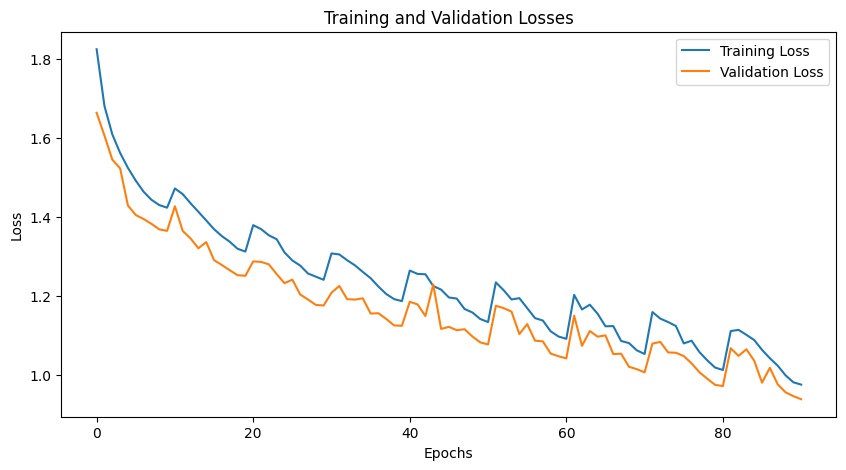

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

Testing Set Accuracy

In [ ]:
num_correct = 0
num_samples = 0
model.eval()

with torch.no_grad():
    for inputs, targets in audio_test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs.data, 1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)

print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/classification_model.pt")

In [ ]:
runtime.unassign()